In [1]:
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from tqdm import tqdm
from glob import glob
import os
import os.path as osp
import json
from pprint import pprint
from collections import Counter

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

In [2]:
# Config.json
raw_data_path = './Raw_Data/train'
width = 256
height = 256
device = torch.device("cuda:0")
batch_size = 32
lr = 1e-3
dropout_rate = 0.2
epochs = 2
prepared_data_path = './Prepared_Data/train'
test_data_path = './Test_Data'
model_save_path = './model_weight'

In [3]:
# 필요한 directory를 만들어주는 Utils
def make_necessary_dir(prepared_data_path, model_save_path):
    os.makedirs(prepared_data_path, exist_ok=True)
    os.makedirs(model_save_path, exist_ok=True)

In [4]:
def get_image_json_path(raw_data_path: str):
    raw_data =sorted(glob(osp.join(raw_data_path, '*')))
    raw_image_json = list()
    for raw_data_path in raw_data:
        Image_name = raw_data_path.split('/')[-1]
        Image = osp.join(raw_data_path, Image_name + '.jpg')
        Json = osp.join(raw_data_path, Image_name + '.json')
        raw_image_json.append((Image, Json))
    
    return raw_image_json

In [5]:
# 5000장 2분 정도 걸림 (512, 384) -> (256,256)
def get_Resized_Image_Dataset(raw_image_json: list) -> None:   
    for (now_image, now_json) in raw_image_json:
        name = str(len(glob(osp.join(prepared_data_path, '*'))) + 1)
        img = cv2.imread(now_image)
        now_json = json.load(open(now_json, 'r'))
        img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tmp_save_path = osp.join(prepared_data_path, name)
        # Save File
        if osp.isdir(tmp_save_path) == False: 
            os.makedirs(tmp_save_path, exist_ok=True)

        cv2.imwrite(osp.join(tmp_save_path, name + '.jpg'), img)
        with open(osp.join(tmp_save_path, name+'.json'), 'w') as f:
            json.dump(now_json, f, indent=4)

In [6]:
# Visualization with matplotlib
def Viz_image(raw_image: str, prepared_image: str):
    raw_img = cv2.imread(raw_image)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    prepared_img = cv2.imread(prepared_image)

    fig, axs = plt.subplots(1,2 ,figsize = (12,6))
    axs[0].imshow(raw_img)
    axs[0].set_title('Raw_Image')

    axs[1].imshow(prepared_img)
    axs[1].set_title('Prepared_Image')

    plt.show()

# Utils Function

In [7]:
# crop
crop_dict = {1 : '딸기',
             2 : '토마토',
             3 : '파프리카',
             4 : '오이', 
             5 : '고추',
             6 : '시설포도'
            }    
# risk
risk_dict = {0 : '정상',
             1 : '초기',
             2 : '중기',
             3 : '말기'}

task_dict = {0 : '정상',
             1 : '병해',
             2 : '생리장해',
            }## 보호제 처리 반응 삭제 tr_json_df['데이터종류'].unique() 3없음
# disease
disease_dict = {'00' : '정상',
                'a1' : '딸기잿빛곰팡이병-1',
                'a2' : '딸기흰가루병-1',
                'a3' : '오이노균병-1',
                'a4' : '오이흰가루병-1',
                'a5' : '토마토흰가루병-1',
                'a6' : '토마토잿빛곰팡이병-1',
                'a7' : '고추탄저병-1',
                'a8' : '고추흰가루병-1',
                'a9' : '파프리카흰가루병-1',
                'a10' : '파프리카잘록병-1',
                'a11' : '시설포도탄저병-1',
                'a12' : '시설포도노균병-1',
                'b1' : '냉해피해-2',
                'b2' : '열과-2',
                'b3' : '칼슘결핍-2',
                'b4' : '일소피해-2',
                'b5' : '축과병-2',
                'b6' : '다량원소결핍 (N)-2',
                'b7' : '다량원소결핍 (P)-2',
                'b8' : '다량원소결핍 (K)-2',
                # 'c1' : '딸기잿빛곰팡이병반응-2',
                # 'c2' : '딸기흰가루병반응-2',
                # 'c3' : '오이노균병반응-2',
                # 'c4' : '오이흰가루병반응-2',
                # 'c5' : '토마토흰가루병반응-2',
                # 'c6' : '토마토잿빛곰팡이병반응-2',
                # 'c7' : '고추탄저병반응-2',
                # 'c8' : '고추흰가루병반응-2',
                # 'c9' : '파프리카흰가루병반응-2',
                # 'c10' : '파프리카잘록병반응-2',
                # 'c11' : '시설포도탄저병반응-2',
                # 'c12' : '시설포도노균병반응-2'
               }

area_dict = {1 : '열매',
             2 : '꽃',
             3 : '잎',
             4 : '가지',
             5 : '줄기',
             6 : '뿌리',
             7 : '해충'}

grow_dict = {11: '유모기',
             12: '생장기',
             13: '착화/과실기',
             21: '발아기',
             22: '개화기',
             23: '신초생장기',
             24: '과실성숙기',
             25: '수확기',
             26: '휴먼기'}

In [8]:
def make_label_encoder_decoder(prepared_data_path):
    path_list = sorted(glob(osp.join(prepared_data_path, '*/*.json')))
    label_set = set()
    all_label_set = set()
    for idx, path in enumerate(path_list):
        now_json = json.load(open(path,'r'))
        now_crop = crop_dict[now_json['annotations']['crop']]
        now_disease = disease_dict[now_json['annotations']['disease']]
        now_risk = risk_dict[now_json['annotations']['risk']] 
        now_area = area_dict[now_json['annotations']['area']]
        now_grow = grow_dict[now_json['annotations']['grow']]
        label_set.add(now_crop + '_' + now_disease + '_' + now_risk)
        all_label_set.add(now_crop + '_' + now_disease + '_' + now_risk + '_' + now_area + '_' + now_grow)
    label_encoder = {key:idx for idx, key in enumerate(sorted(label_set))}
    label_decoder = {val:key for key, val in label_encoder.items()}
    all_label_encoder = {key:idx for idx, key in enumerate(sorted(all_label_set))}
    all_label_decoder = {val:key for key, val in all_label_encoder.items()}
    return label_encoder, label_decoder, all_label_encoder , all_label_decoder

In [9]:
def make_dataset_label_encoder_decoder(prepared_data_path):
    path_list = sorted(glob(osp.join(prepared_data_path, '*/*.json')))
    label_set = set()
    all_label_set = set()
    for idx, path in enumerate(path_list):
        now_json = json.load(open(path,'r'))
        now_crop = now_json['annotations']['crop']
        now_disease = now_json['annotations']['disease']
        now_risk = now_json['annotations']['risk']
        now_area = now_json['annotations']['area']
        now_grow = now_json['annotations']['grow']
        label_set.add(f'{now_crop}_{now_disease}_{now_risk}')
        all_label_set.add(f'{now_crop}_{now_disease}_{now_risk}_{now_area}_{now_grow}')
    label_encoder = {key:idx for idx, key in enumerate(sorted(label_set))}
    label_decoder = {val:key for key, val in label_encoder.items()}
    all_label_encoder = {key:idx for idx, key in enumerate(sorted(all_label_set))}
    all_label_decoder = {val:key for key, val in all_label_encoder.items()}
    return label_encoder, label_decoder, all_label_encoder , all_label_decoder

In [15]:
def Set_Dataset_CSV(path):
    # dict crop_dict들이 필요함.
    # dict를 이용해 csv를 만들 수 있음.
    data = {
        'name' : [],
        'path' : [],
        'Described_label' : [], # 0
        'Described_delabel' : [], # '고추_고추탄저병-1_중기'
        'Described_all_label' : [], # 0,
        'Described_all_delabel' : [], # '고추_고추탄저병-1_중기_열매_착화/과실기',

        'label' : [], # 0,
        'delabel' : [], # '1_00_0',
        'all_label' : [], # 0,
        'all_delabel' : [], #'1_00_0_3_11',
    }
    path = sorted(glob(osp.join(path, '*')))
    for now_path in path:
        now_name = now_path.split('/')[-1]
        now_image_path = osp.join(now_path,now_name+'.jpg')
        now_json_path = osp.join(now_path,now_name+'.json')
        now_json = json.load(open(now_json_path,'r'))
        now_crop = now_json['annotations']['crop']
        now_disease = now_json['annotations']['disease']
        now_risk = now_json['annotations']['risk']
        now_area = now_json['annotations']['area']
        now_grow = now_json['annotations']['grow']

        Described_delabel = f'{crop_dict[now_crop]}_{disease_dict[now_disease]}_{risk_dict[now_risk]}'
        Described_label = label_encoder[Described_delabel]
        Described_all_delabel = f'{crop_dict[now_crop]}_{disease_dict[now_disease]}_{risk_dict[now_risk]}_{area_dict[now_area]}_{grow_dict[now_grow]}'
        Described_all_label = all_label_encoder[Described_all_delabel]

        delabel = f'{now_crop}_{now_disease}_{now_risk}'
        label = dataset_label_encoder[delabel]
        all_delabel = f'{now_crop}_{now_disease}_{now_risk}_{now_area}_{now_grow}'
        all_label = dataset_all_label_encoder[all_delabel]

        data['name'].append(now_name)
        data['path'].append(now_path)

        data['Described_label'].append(Described_label)
        data['Described_delabel'].append(Described_delabel)
        data['Described_all_label'].append(Described_all_label)
        data['Described_all_delabel'].append(Described_all_delabel)

        data['label'].append(label)
        data['delabel'].append(delabel)
        data['all_label'].append(all_label)
        data['all_delabel'].append(all_delabel)

    df = pd.DataFrame(data)
    df.to_csv(osp.join('./','train.csv'))

# Dataset

In [11]:
# Transform
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensor

train_albumentation =  A.Compose([
                  A.OneOf([
                           A.HorizontalFlip(p=1.0),
                           A.VerticalFlip(p=1.0),
                           A.RandomRotate90(p=1.0)
                           ],p=0.75),
                  A.RandomBrightness(p=0.5, limit=(-0.2, 0.25)),
                  A.RandomContrast(p=0.5, limit=(-0.25, 0.25)),
                  ToTensorV2(p=1.0)# dtype float32, transpose 한번에 
                  ])
test_albumentation =  A.Compose([
                      ToTensorV2(p=1.0)# dtype float32, transpose 한번에 
                      ])  


In [12]:
class CustomDataset(Dataset):
    def __init__(self, path, label, label_encoder=None, label_decoder=None,transform=None, mode='train'):
        self.path = path
        self.label = label
        self.label_encoder = label_encoder
        self.label_decoder = label_decoder
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        data_path = self.path[idx]
        data_name = data_path.split('/')[-1]

        # 전처리
        image = cv2.imread(f"{data_path}/{data_name}.jpg")
        image = self.transform(image=image)['image'] # alubmentation transform

        if self.mode == 'train':
            data_json = json.load(open(f"{data_path}/{data_name}.json", 'r'))
            crop = data_json['annotations']['crop']
            disease = data_json['annotations']['disease']
            risk = data_json['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            return {
                'image' : torch.tensor(image/255, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype= torch.long) 
                # 이거 꼭 tensor형태로 return 해야하나?
            }
        else:
            return {
                'image' : image
            }

In [13]:
make_necessary_dir(prepared_data_path, model_save_path)
raw_image_json = get_image_json_path(raw_data_path)
get_Resized_Image_Dataset(raw_image_json)  

In [16]:
label_encoder, label_decoder, all_label_encoder, all_label_decoder = make_label_encoder_decoder(prepared_data_path)
dataset_label_encoder, dataset_label_decoder, dataset_all_label_encoder, dataset_all_label_decoder = make_dataset_label_encoder_decoder(prepared_data_path)
Set_Dataset_CSV(prepared_data_path)

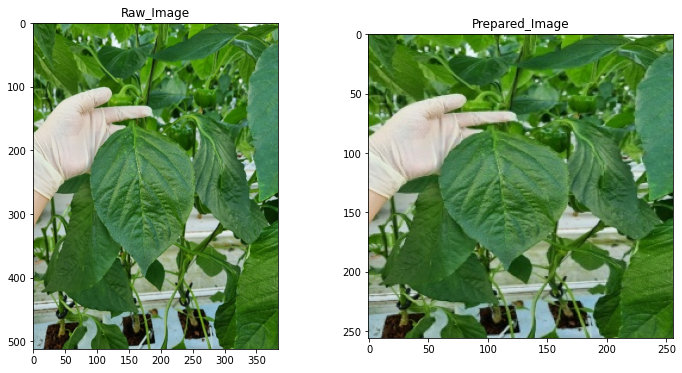

In [17]:
Viz_image('/home/hj/Study/MLops/Raw_Data/train/10027/10027.jpg', '/home/hj/Study/MLops/Prepared_Data/train/1/1.jpg')

In [18]:
Set_Dataset_CSV(prepared_data_path)

In [19]:
pd.read_csv('./train.csv')

,Unnamed: 0,name,path,Described_label,Described_delabel,Described_all_label,Described_all_delabel,label,delabel,all_label,all_delabel
0,0,1,./Prepared_Data/train/1,19,파프리카_다량원소결핍 (P)-2_초기,29,파프리카_다량원소결핍 (P)-2_초기_잎_착화/과실기,9,3_b7_1,15,3_b7_1_3_13
1,1,10,./Prepared_Data/train/10,24,파프리카_파프리카흰가루병-1_초기,38,파프리카_파프리카흰가루병-1_초기_잎_착화/과실기,4,3_a9_1,10,3_a9_1_3_13
2,2,100,./Prepared_Data/train/100,16,토마토_토마토흰가루병-1_중기,26,토마토_토마토흰가루병-1_중기_잎_생장기,2,2_a5_2,4,2_a5_2_3_12
3,3,1000,./Prepared_Data/train/1000,1,고추_다량원소결핍 (K)-2_초기,1,고추_다량원소결핍 (K)-2_초기_잎_착화/과실기,16,5_b8_1,27,5_b8_1_3_13
4,4,10000,./Prepared_Data/train/10000,14,오이_정상_정상,22,오이_정상_정상_잎_착화/과실기,11,4_00_0,20,4_00_0_3_13
...,...,...,...,...,...,...,...,...,...,...,...
11529,11529,9995,./Prepared_Data/train/9995,5,딸기_정상_정상,7,딸기_정상_정상_잎_유모기,0,1_00_0,0,1_00_0_3_11
11530,11530,9996,./Prepared_Data/train/9996,5,딸기_정상_정상,7,딸기_정상_정상_잎_유모기,0,1_00_0,0,1_00_0_3_11
11531,11531,9997,./Prepared_Data/train/9997,14,오이_정상_정상,22,오이_정상_정상_잎_착화/과실기,11,4_00_0,20,4_00_0_3_13
11532,11532,9998,./Prepared_Data/train/9998,20,파프리카_정상_정상,33,파프리카_정상_정상_잎_유모기,3,3_00_0,7,3_00_0_3_11


In [20]:
train_dataset = CustomDataset(
    path=sorted(glob(osp.join(prepared_data_path,'*'))),
    label=None,
    label_encoder=dataset_label_encoder,
    label_decoder=dataset_label_decoder,
    transform=train_albumentation,
    mode='train'
)

/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),


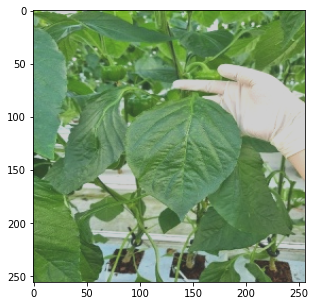

In [21]:
# test code
fit, ax = plt.subplots(figsize=(5,5))
ax.imshow((train_dataset[0]['image']).numpy().transpose(1,2,0))
plt.show()

In [22]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [23]:
class CNN(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.classifier1 = nn.Linear(1000,25)
        self.dropout = nn.Dropout(rate)
    
    def forward(self, inputs):
        output = self.model(inputs)
        output = self.dropout(self.classifier1(output))# dropout 조심.
        return output

In [24]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['image'].to(device)
    label = batch_item['label'].to(device)

    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            label_out = model(img) # model(img, csv_feature) 
            loss = criterion_class(label_out, label)
        loss.backward()
        optimizer.step()
        
        return loss, torch.argmax(label_out, dim=1).detach().cpu().numpy(), label.detach().cpu().numpy()
    else:
        model.eval()
        with torch.no_grad():
            label_out = model(img) # model(img, csv_feature) 
            loss = criterion_class(label_out, label)
        return loss, torch.argmax(label_out, dim=1).detach().cpu().numpy(), label.detach().cpu().numpy(),

In [26]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

kf = StratifiedKFold(n_splits=5, shuffle=True)
train_csv = pd.read_csv('./train.csv')
for NUM_FOLD, (train_idx, valid_idx) in enumerate(kf.split(train_csv['path'], train_csv['label'])):
    train_dataset = CustomDataset(
        path=sorted(train_csv.iloc[train_idx]['path'].tolist()),
        label=None,
        label_encoder=dataset_label_encoder,
        label_decoder=dataset_label_decoder,
        transform=train_albumentation,
        mode='train'
    )
    val_dataset = CustomDataset(
        path=sorted(train_csv.iloc[valid_idx]['path'].tolist()),
        label=None,
        label_encoder=dataset_label_encoder,
        label_decoder=dataset_label_decoder,
        transform=test_albumentation,
        mode='train'
    )

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

    max_f1_score = 0
    model = CNN(25, rate=0.2)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_class = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10, 
        T_mult=1,
        eta_min=1e-6, 
        last_epoch=-1
    )
    for epoch in range(epochs):
        total_loss, val_total_loss = 0, 0
        
        tqdm_dataset = tqdm(enumerate(train_dataloader), total = len(train_dataloader))
        training = True
        true_label_list = [];pred_label_list = [];
        val_true_label_list = [];val_pred_label_list = []

        for batch, batch_item in tqdm_dataset:

    #        batch_loss, batch_acc = train_step(batch_item, training)
            loss, pred_label, true_label  = train_step(batch_item, training)
            total_loss += loss;
                
            tqdm_dataset.set_postfix({
                'Train Epoch': epoch + 1,
                'Total Loss' : '{:04f}'.format(total_loss/(batch+1)),
            })
            true_label_list.extend(list(true_label));pred_label_list.extend(list(pred_label))
        print(f"\nTrain F-1 Score: {f1_score(true_label_list, pred_label_list, average='macro')}")
        loss_plot.append(total_loss/(batch+1))
        metric_plot.append(f1_score(true_label_list, pred_label_list, average='macro'))
        
        tqdm_dataset = tqdm(enumerate(valid_dataloader), total = len(valid_dataloader))
        training = False
        for batch, batch_item in tqdm_dataset:
            loss, pred_label, true_label  = train_step(batch_item, training)
            val_total_loss += loss;
            
            tqdm_dataset.set_postfix({
                'Validation Epoch': epoch + 1,
                'Total Loss' : '{:04f}'.format(val_total_loss/(batch+1)),
            })
            val_true_label_list.extend(list(true_label));val_pred_label_list.extend(list(pred_label))
        validation_f1_score = f1_score(val_true_label_list, val_pred_label_list, average='macro')
        print(f"\nValidation F-1 Score: {validation_f1_score}")
        val_loss_plot.append(val_total_loss/(batch+1))
        val_metric_plot.append(validation_f1_score)
        
        if validation_f1_score > max_f1_score:
            max_f1_score = validation_f1_score
            torch.save(model.state_dict(), osp.join(model_save_path,f'{NUM_FOLD}_best_model.pt'))
    
    

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/hj/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.1MB/s]
  0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad


Train F-1 Score: 0.2610443633656294



  0%|          | 0/73 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Validation F-1 Score: 0.42364048010963384


  0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Train F-1 Score: 0.4546331750885067



  0%|          | 0/73 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Validation F-1 Score: 0.4907258056719909


  0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Train F-1 Score: 0.25985352244016136



  0%|          | 0/73 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Validation F-1 Score: 0.4086864047695353


  0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Train F-1 Score: 0.43329291711777784



/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
  0%|          | 0/73 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Validation F-1 Score: 0.5855254467454891


  0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Train F-1 Score: 0.2305233526646159



  0%|          | 0/73 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Validation F-1 Score: 0.4447690682018494


  0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Train F-1 Score: 0.41310171033063076



  0%|          | 0/73 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso


Validation F-1 Score: 0.4638608089128755


  0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image' : torch.tensor(image/255, dtype=torch.float32),
/tmp/ipykernel_16706/1378155160.py:28: UserWarning: To copy construct from a tenso

KeyboardInterrupt: 